In [1]:
import math
import random
from collections import Counter
from collections import OrderedDict
from operator import itemgetter

import matplotlib.font_manager as fm
import numpy as np
import pandas as pd
from konlpy.tag import Komoran
from matplotlib import pyplot as plt
from nltk import Text
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud

In [2]:
font_path = '/Library/Fonts/NanumBarunGothic.otf'
plt.rc('font', family=fm.FontProperties(fname=font_path, size=50).get_name())
komoran = Komoran()

# Input benchmark and target dataset list

In [3]:
dict_target = dict()

dict_target['benchmark'] = ['일취월장', '완공', '뼈아대'] 
dict_target['일취월장'] = ['일취월장'] 
dict_target['완공'] = ['완공'] 
dict_target['뼈아대'] = ['뼈아대'] 

dict_target['personal'] = ['Daily_Report', 'Weekly_Report', 'Monthly_Report', '글쓰기'] 
dict_target['멘토_브런치'] = ['멘토_브런치']
dict_target['신박사_브런치'] = ['신박사_브런치']
dict_target['신영준_페이스북'] = ['신영준_페이스북']
dict_target['연예_기사'] = ['연예_기사'] 

# Data Read

## .txt 읽은 dict

In [4]:
dict_target.keys()

dict_keys(['benchmark', '일취월장', '완공', '뼈아대', 'personal', '멘토_브런치', '신박사_브런치', '신영준_페이스북', '연예_기사'])

In [5]:
def get_dict_string(dict_target, target_key):
    """
    text 하위 폴더(폴더명: target_key)의 .txt 파일명을 key, .txt를 읽은 string을 value로 반환하는 dict 생산. 
    :param dict_target: dict
    :param target_key: string
    :return: dict
    """
    dict_topic = dict()
    for target_file in dict_target[target_key]:
        dict_topic[target_file] = open('text/{0}/{1}.txt'.format(target_key, target_file),
                                       "r", encoding="utf-8").read()

    return dict_topic

In [6]:
def get_dict_strings(dict_target):
    """
    text 하위폴더별로 .txt 파일명을 key, .txt를 읽은 string을 value로 반환하는 dict 생산. 
    :param dict_target: dict
    :return: dict
    """
    dict_strings = dict()
    for target_key in dict_target.keys():
        dict_strings[target_key] = get_dict_string(dict_target, target_key)
        
    return dict_strings

In [7]:
def get_dict_merged_strings(dict_strings):
    """
    text 하위폴더명을 key, text 하위폴더의 모든 .txt 읽은 string을 value로 반환하는 dict 생산. 
    :param dict_target: dict
    :return: dict
    """
    dict_merged_strings = dict()

    for key_topic in dict_strings.keys():
        for key_file in dict_strings[key_topic].keys():
            if key_topic in dict_merged_strings.keys():
                dict_merged_strings[key_topic] += dict_strings[key_topic][key_file]
            else:
                dict_merged_strings[key_topic] = dict_strings[key_topic][key_file]

    return dict_merged_strings

In [8]:
dict_strings = get_dict_strings(dict_target)

In [9]:
dict_merged_strings = get_dict_merged_strings(dict_strings)

## .txt을 읽은 dict -> noun의 list로

In [10]:
def get_nouns_from_topics(dict_merged_strings, komoran):
    """
    dict_merged_strings의 key를 key, dict_merged_strings의 value를 noun만 뽑은 list를 value로 반환하는 dict 생산. 
    :param dict_merged_strings: dict. get_dict_merged_strings 함수로 처리된 결과물.
    :param komoran: konlpy object.
    :return: dict
    """
    dict_nouns = dict()
    for key in dict_merged_strings.keys():
        dict_nouns[key] = komoran.nouns("\n".join(
            [s for s in dict_merged_strings[key].split("\n") if s]))
        
    return dict_nouns

In [11]:
dict_nouns = get_nouns_from_topics(dict_merged_strings, komoran)

# Data Explore

In [12]:
for key in dict_nouns.keys():
    print('# of nouns in {0}: {1}'.format(key, len(dict_nouns[key])))

# of nouns in benchmark: 12357
# of nouns in 일취월장: 5691
# of nouns in 완공: 3457
# of nouns in 뼈아대: 3209
# of nouns in personal: 10084
# of nouns in 멘토_브런치: 3362
# of nouns in 신박사_브런치: 3818
# of nouns in 신영준_페이스북: 1606
# of nouns in 연예_기사: 1132


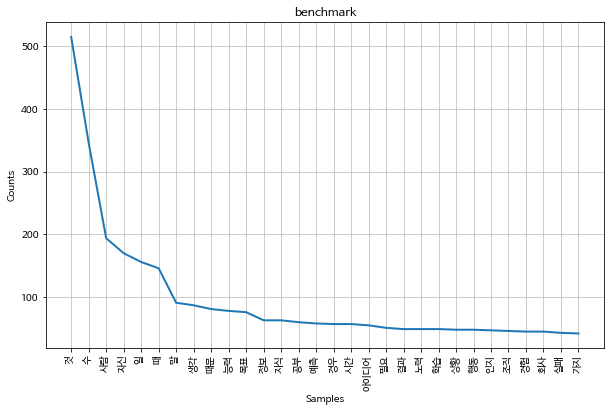

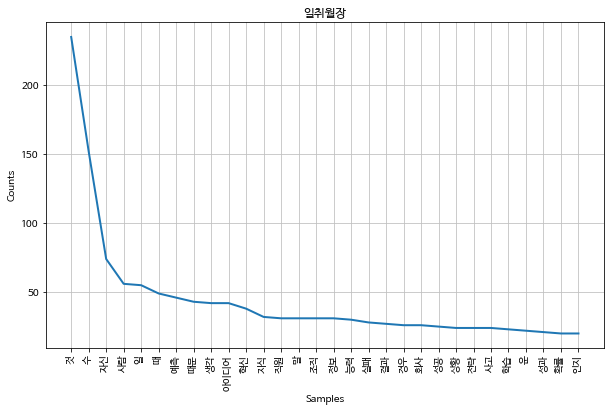

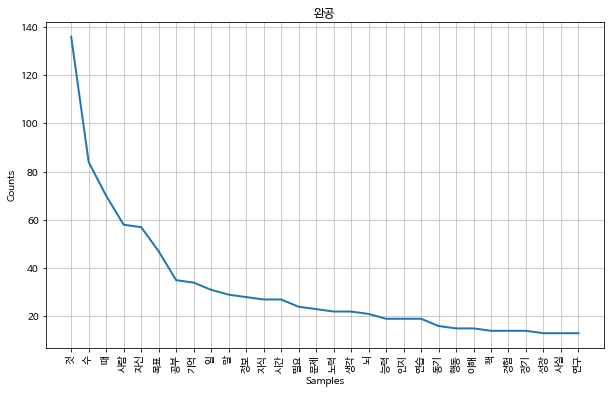

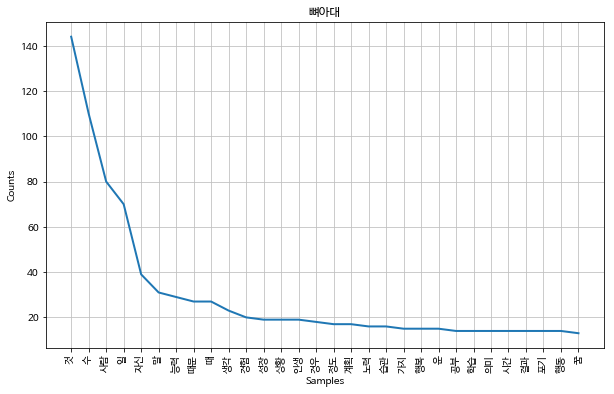

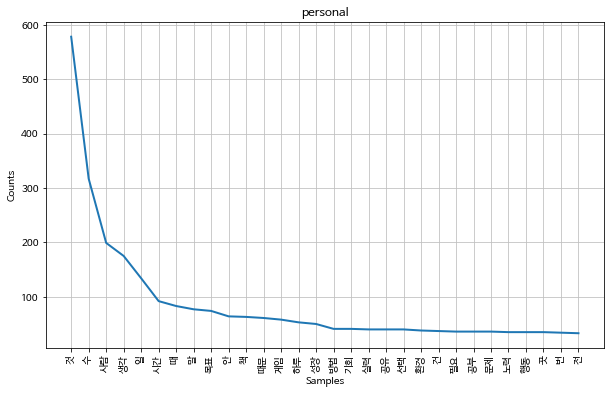

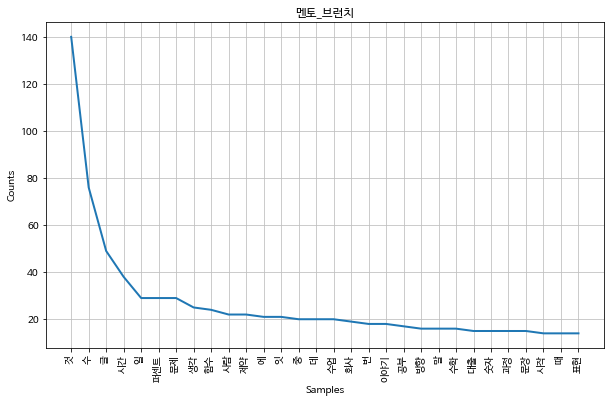

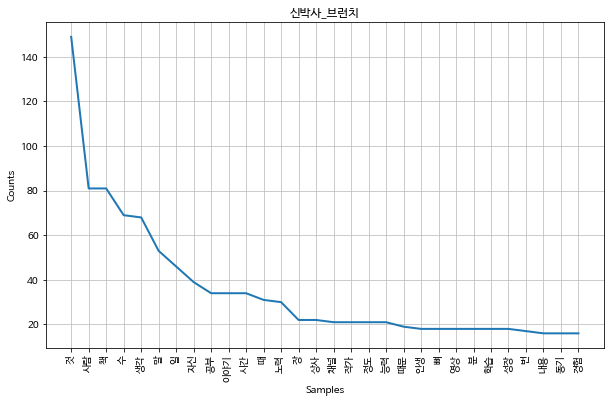

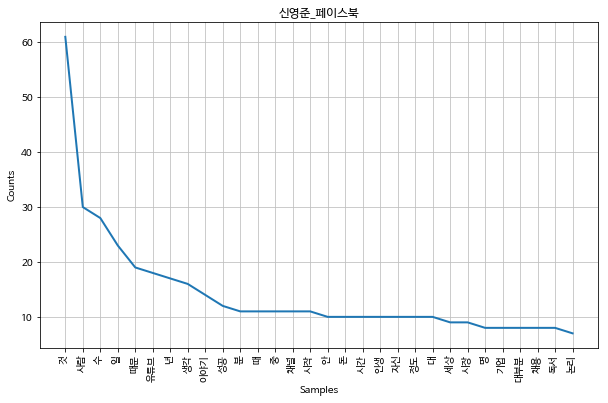

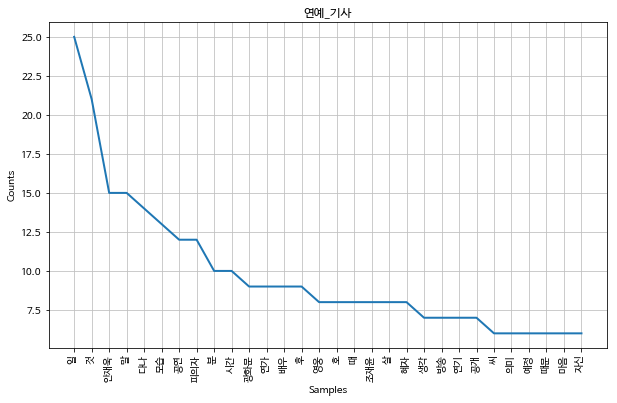

In [13]:
for category in dict_nouns.keys():
    plt.figure(figsize=(10, 6))
    plt.title(category)

    # 30개 noun 까지만 보여줌.
    Text(dict_nouns[category], name=category).plot(30)
    plt.show()

-> 지수적으로 떨어지는게 자연적인 모양. 오히려 지수적으로 떨어지지 않으면 데이터가 부족한 것이라 판단.

## noun 빈도수를 포함한 dict로

In [14]:
def get_nouns_frequency(dict_nouns):
    """
    dict_nouns key를 key, dict_nouns value를 noun별 빈도수 dict를 value로 반환하는 dict 생산.
    :param dict_nouns: dict. get_nouns_from_topics 함수로 처리된 결과물.
    :return: dict
    """
    dict_frequency = dict()
    for category in dict_nouns.keys():
        text_vocab = Text(dict_nouns[category], name=category).vocab()
        dict_frequency[category] = OrderedDict(sorted(text_vocab.items(), key=itemgetter(1), reverse=True))
    
    return dict_frequency

In [15]:
dict_frequency = get_nouns_frequency(dict_nouns)

# Data Preprocess

의미 부족한 단어 제거 (10 단어 이상의 경우만 체크함)

In [16]:
delete_words_benchmark = ['것', '수', '때', '때문', '경우', '필요', '가지', '정도', '뿐', '년', 
                          '등', '데' '개', '대부분', '번', '점', '관련', '전', '중', '자', '분', 
                          '만', '게', '동안', '뜻', '곳', '언가']
delete_words_personal = ['것', '수', '때', '안', '때문', '건', '필요', '곳', '번', '전', '중', '정도',
                         '년', '거', '점', '.so', '라고', '부분', '구체', '뿐', '자체', '가지', '밖',
                         '날', '분', '.com', '데', '개', '의', '을', '자', '션', '한', '회', '줄', '영',
                         '만', '명', '적', '시']
delete_words_huge_portion = ['사람', '자신', '일', '말', '생각']
delete_words = delete_words_benchmark + delete_words_personal + delete_words_huge_portion

In [17]:
def get_preprocessed_nouns(dict_nouns, delete_words):
    """
    dict_nouns key를 key, dict_nouns value를 value로 반환하는 dict 생산.
    단, delete_words 에 없는 단어만 value에 포함함.
    :param dict_nouns: dict. get_nouns_from_topics 함수로 처리된 결과물.
    :param delete_words: list. 삭제할 key 정보를 가진 list
    :return: dict
    """
    dict_nouns_ppd = dict_nouns.copy()

    # delete_words에 있는 단어 제거
    for category in dict_nouns_ppd.keys():
        for word in delete_words:
            try:
                dict_nouns_ppd[category] = list(filter(lambda x: x!=word, dict_nouns_ppd[category]))
            except KeyError:
                continue
    
    return dict_nouns_ppd

In [18]:
dict_nouns_ppd = get_preprocessed_nouns(dict_nouns, delete_words)

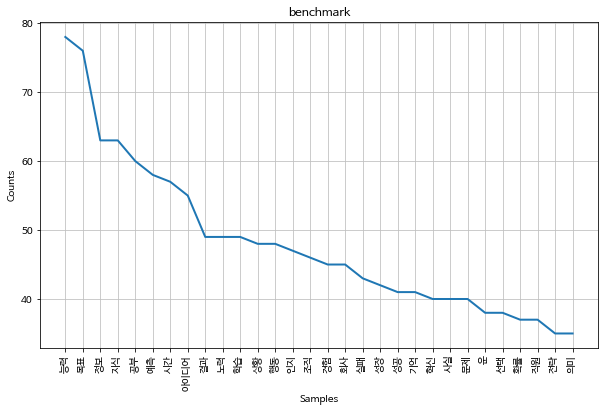

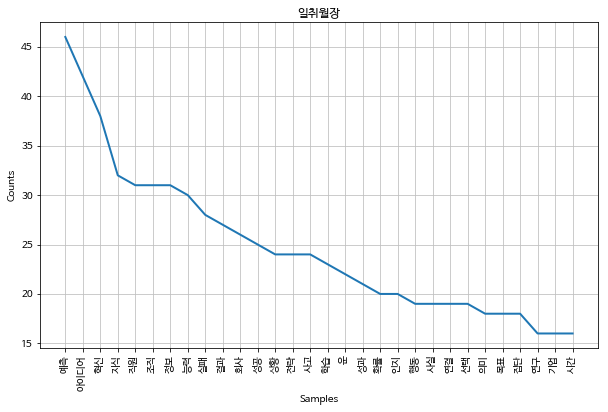

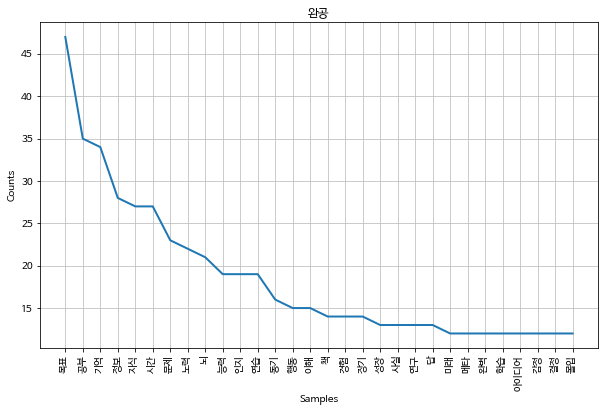

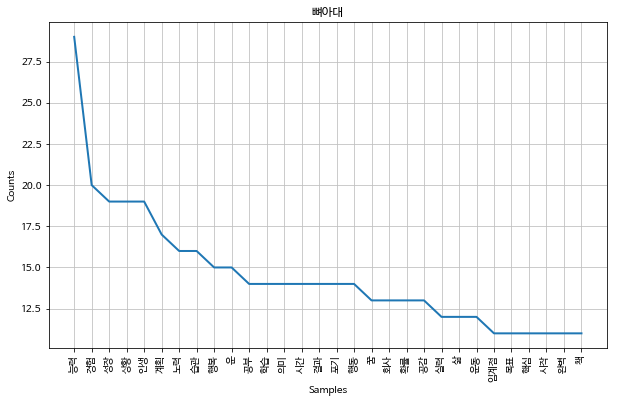

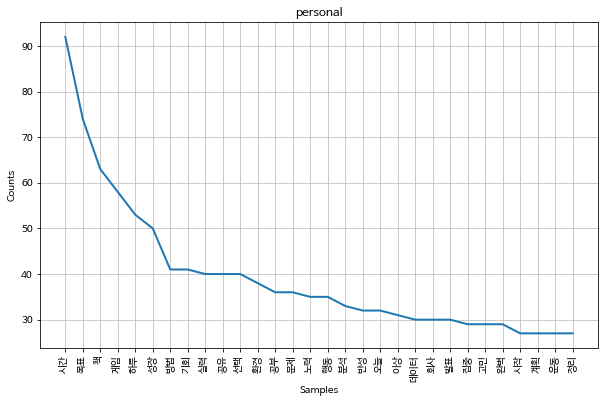

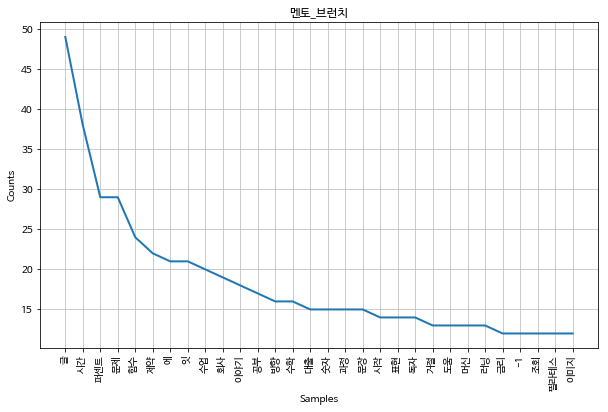

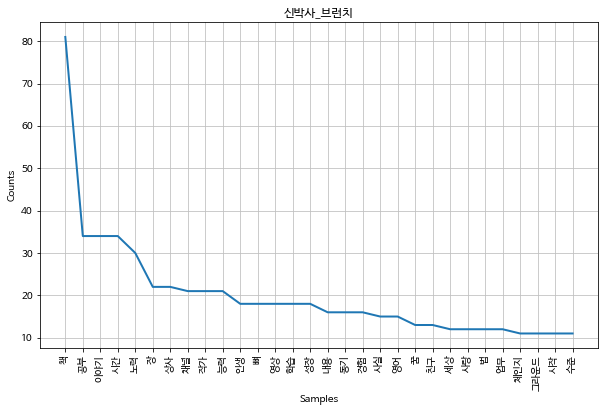

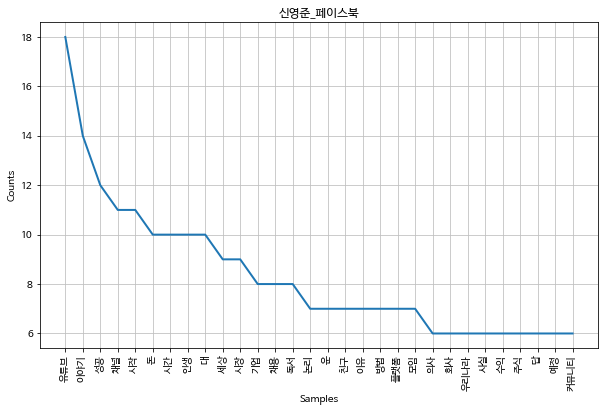

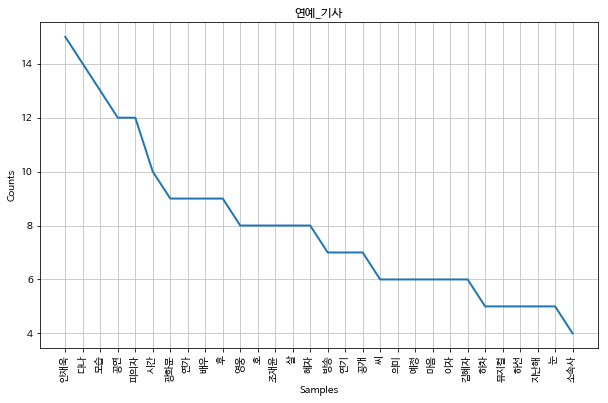

In [19]:
for category in dict_nouns_ppd.keys():
    plt.figure(figsize=(10, 6))
    plt.title(category)
    Text(dict_nouns_ppd[category], name=category).plot(30)
    plt.show()

In [20]:
def get_preprocessed_nouns_frequency(dict_frequency, delete_words):
    """
    dict_frequency key를 key, dict_frequency value를 value로 반환하는 dict 생산.
    단, delete_words 에 없는 단어만 value의 key에 포함함.
    :param dict_frequency: dict. get_nouns_frequency 함수로 처리된 결과물.
    :param delete_words: list. 삭제할 key 정보를 가진 list
    :return: dict
    """
    dict_frequency_ppd = dict_frequency.copy()

    # delete_words에 있는 단어 제거
    for category in dict_frequency_ppd.keys():
        for word in delete_words:
            try:
                dict_frequency_ppd[category].pop(word)
            except KeyError:
                continue
                
    return dict_frequency_ppd

In [21]:
dict_frequency_ppd = get_preprocessed_nouns_frequency(dict_frequency, delete_words)

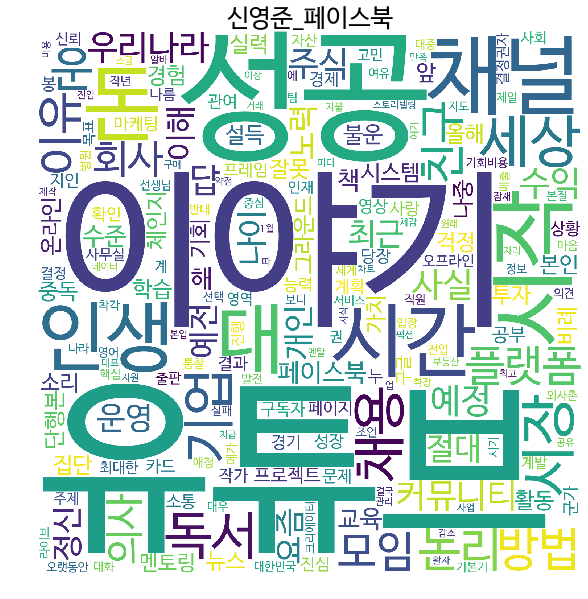

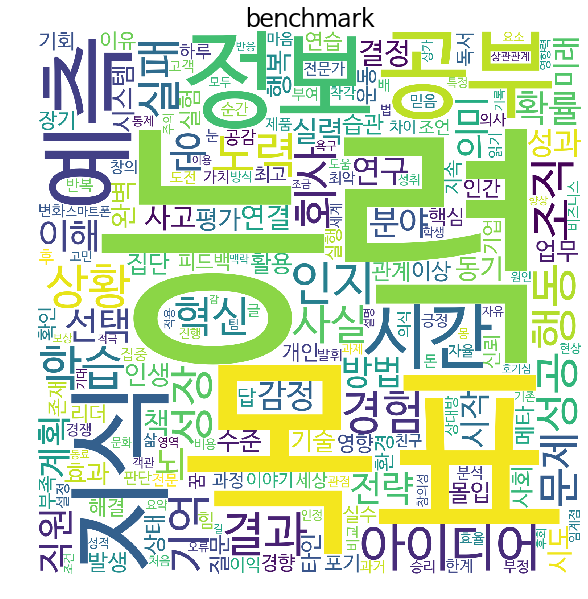

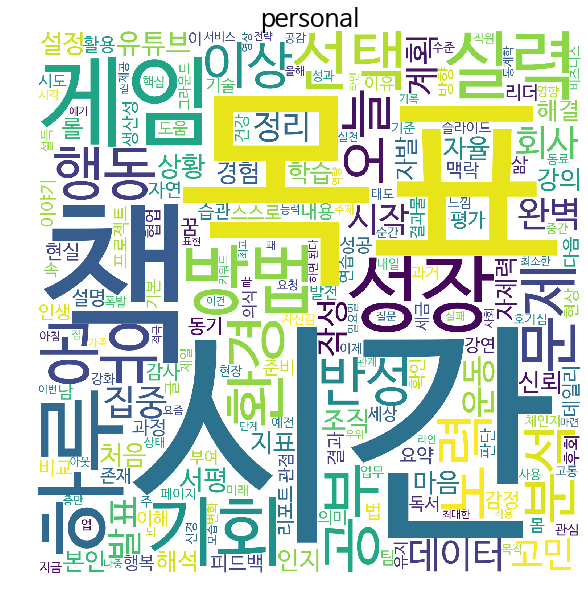

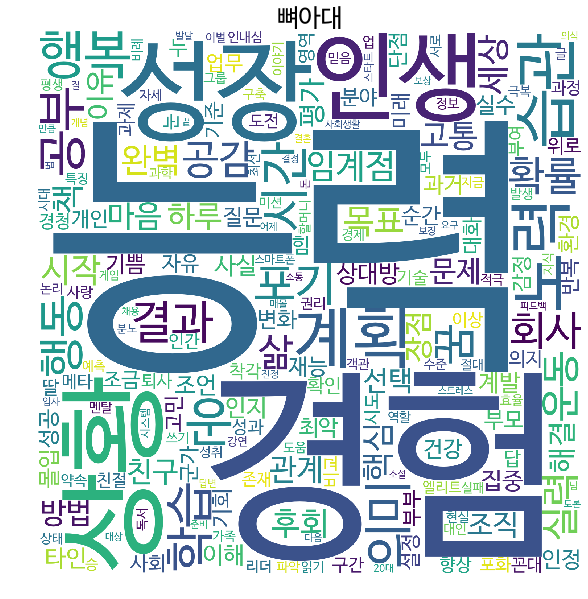

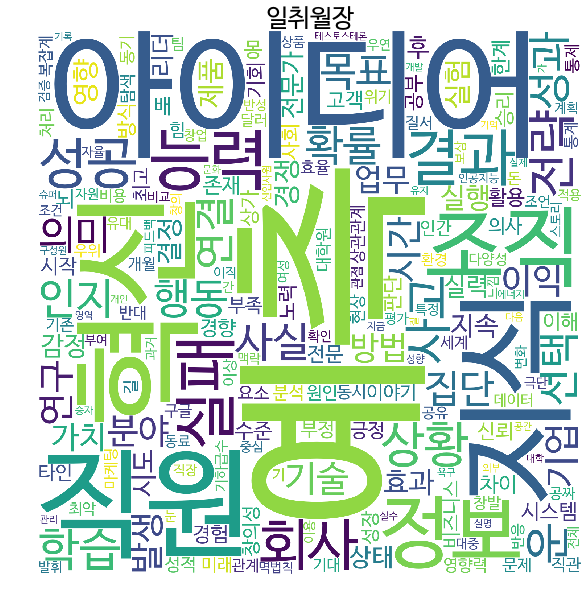

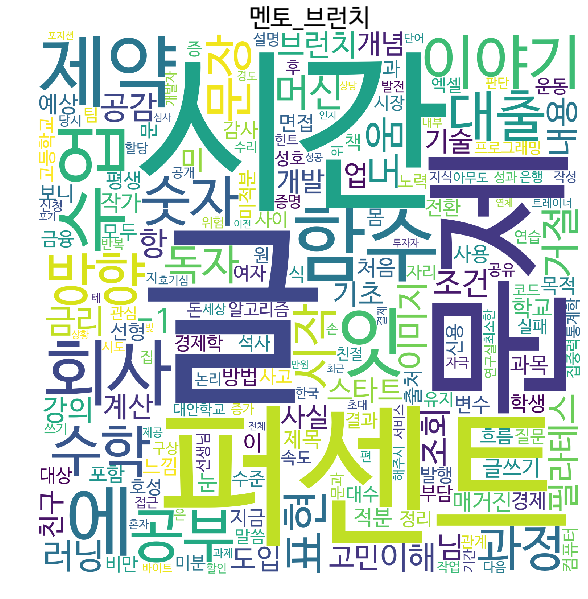

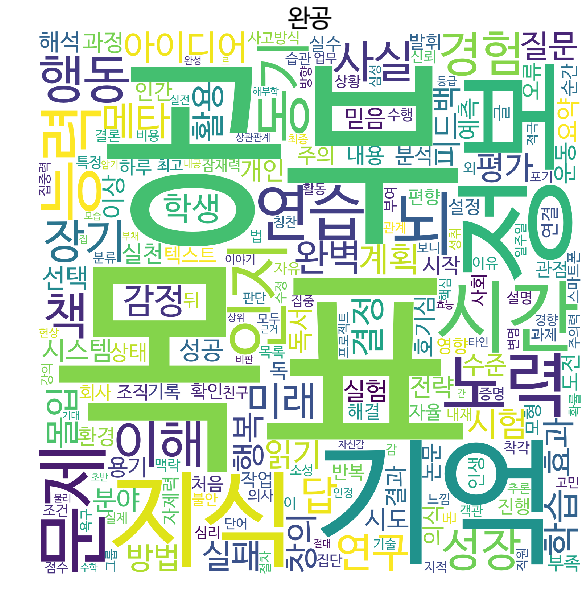

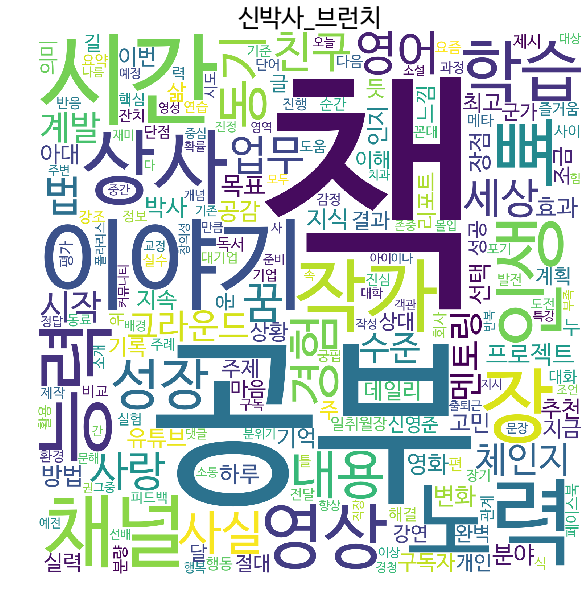

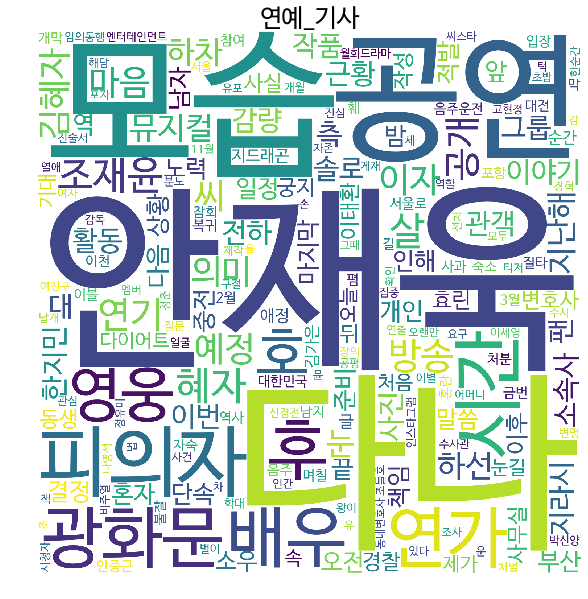

In [22]:
for category in set(dict_frequency_ppd.keys()):
    wc = WordCloud(width = 1500, height = 1500, background_color="white", font_path=font_path)
    plt.figure( figsize=(20,10))
    plt.title(category, fontsize=25)
    plt.imshow(wc.generate_from_frequencies(dict_frequency_ppd[category]))
    plt.axis("off")
    plt.show()

# Analysis

## sse_score

In [23]:
def get_score(dict_frequency_benchmark, dict_frequency_test, score_type):
    """
    get_nouns_frequency 함수로 처리된 결과 dict내의 두 value 선택하면 단어별 빈도 비율의 차이를 0~1점 사이의 score로 반환한다.
    1점에 가까울수록 유사하다.
    :param dict_frequency_benchmark: dict. get_nouns_frequency 함수로 처리된 결과물의 value.
    :param dict_frequency_test: dict. get_nouns_frequency 함수로 처리된 결과물의 value.
    :param score_type: string. choose 'sse' or 'log_sse'
    :return: float
    """
    
    df_benchmark = pd.DataFrame.from_dict(dict_frequency_benchmark, 
                                          orient='index', columns=['word_count'])
    df_test = pd.DataFrame.from_dict(dict_frequency_test, 
                                     orient='index', columns=['word_count'])

    # 1회 나온 단어 log 씌우면 0되는 것 방지
    df_benchmark['log_word_count'] = np.log(df_benchmark.word_count + 1)
    df_test['log_word_count'] = np.log(df_test.word_count + 1)
    
    df_benchmark['word_portion'] = df_benchmark.word_count.apply(
        lambda x: x / df_benchmark.word_count.sum())
    df_test['word_portion'] = df_test.word_count.apply(
        lambda x: x / df_test.word_count.sum())
    
    df_benchmark['log_word_portion'] = df_benchmark.log_word_count.apply(
        lambda x: x / df_benchmark.log_word_count.sum())
    df_test['log_word_portion'] = df_test.log_word_count.apply(
        lambda x: x / df_test.log_word_count.sum())
    
    
    df_merge = pd.merge(df_benchmark, df_test, left_index=True, right_index=True, how='outer',
                        suffixes=('_benchmark', '_test'))
    df_merge.fillna(0.0, inplace=True)
    df_merge['sse'] = (df_merge.word_portion_benchmark - df_merge.word_portion_test) ** 2
    df_merge['log_sse'] = (df_merge.log_word_portion_benchmark - df_merge.log_word_portion_test) ** 2
    
    if score_type == 'sse':
        return 1 - math.sqrt(df_merge.sse.sum())
    elif score_type == 'log_sse':
        return 1 - math.sqrt(df_merge.log_sse.sum())

In [24]:
df_sse = pd.DataFrame()
for category_a in dict_frequency_ppd.keys():
    for category_b in dict_frequency_ppd.keys():
        df_sse = df_sse.append([[category_a, category_b,
                                get_score(
                                    dict_frequency_ppd[category_a], dict_frequency_ppd[category_b], 'sse')]],
                               ignore_index=True)
df_sse.columns = ['category_a', 'category_b', 'score']
df_sse.pivot(index='category_a', columns='category_b', values='score')
# pd.pivot_table(df_sse, index='category_a', columns='category_b', values='score')

category_b,benchmark,personal,멘토_브런치,뼈아대,신박사_브런치,신영준_페이스북,연예_기사,완공,일취월장
category_a,,,,,,,,,
benchmark,1.000000,0.966996,0.946822,0.970688,0.954158,0.949596,0.933480,0.971814,0.980389
personal,0.966996,1.000000,0.947837,0.960877,0.954972,0.948695,0.933068,0.957888,0.958019
멘토_브런치,0.946822,0.947837,1.000000,0.940875,0.938759,0.936706,0.926634,0.940192,0.942195
뼈아대,0.970688,0.960877,0.940875,1.000000,0.952004,0.945517,0.929502,0.954086,0.956583
신박사_브런치,0.954158,0.954972,0.938759,0.952004,1.000000,0.945136,0.926097,0.948465,0.945411
신영준_페이스북,0.949596,0.948695,0.936706,0.945517,0.945136,1.000000,0.926047,0.939572,0.945553
연예_기사,0.933480,0.933068,0.926634,0.929502,0.926097,0.926047,1.000000,0.925904,0.930617
완공,0.971814,0.957888,0.940192,0.954086,0.948465,0.939572,0.925904,1.000000,0.956507
일취월장,0.980389,0.958019,0.942195,0.956583,0.945411,0.945553,0.930617,0.956507,1.000000


In [25]:
# log_sse -> log는 의도와는 좀 다르게 나오는 것 같음. 전처리 의도는 맞는데 왜 그럴까?
df_sse = pd.DataFrame()
for category_a in dict_frequency_ppd.keys():
    for category_b in dict_frequency_ppd.keys():
        df_sse = df_sse.append([[category_a, category_b,
                                get_score(
                                    dict_frequency_ppd[category_a], dict_frequency_ppd[category_b], 'log_sse')]],
                               ignore_index=True)
df_sse.columns = ['category_a', 'category_b', 'score']
df_sse.pivot(index='category_a', columns='category_b', values='score')

category_b,benchmark,personal,멘토_브런치,뼈아대,신박사_브런치,신영준_페이스북,연예_기사,완공,일취월장
category_a,,,,,,,,,
benchmark,1.000000,0.980679,0.968160,0.977635,0.973140,0.962633,0.952168,0.978981,0.987153
personal,0.980679,1.000000,0.967892,0.971862,0.972429,0.962750,0.951658,0.971881,0.976431
멘토_브런치,0.968160,0.967892,1.000000,0.961502,0.963295,0.955176,0.947120,0.962633,0.965057
뼈아대,0.977635,0.971862,0.961502,1.000000,0.968871,0.958840,0.947886,0.968320,0.970260
신박사_브런치,0.973140,0.972429,0.963295,0.968871,1.000000,0.960940,0.948681,0.968148,0.969416
신영준_페이스북,0.962633,0.962750,0.955176,0.958840,0.960940,1.000000,0.943189,0.957446,0.960721
연예_기사,0.952168,0.951658,0.947120,0.947886,0.948681,0.943189,1.000000,0.947466,0.949746
완공,0.978981,0.971881,0.962633,0.968320,0.968148,0.957446,0.947466,1.000000,0.971898
일취월장,0.987153,0.976431,0.965057,0.970260,0.969416,0.960721,0.949746,0.971898,1.000000


In [26]:
# for column order
df_sse_pivot = df_sse.pivot(index='category_a', columns='category_b', values='score')
list_order = ['benchmark',
              'personal',
              '신박사_브런치',
              '신영준_페이스북',
              '멘토_브런치',
              '연예_기사',
              '뼈아대',
              '일취월장',
              '완공']
df_sse_pivot[list_order].reindex(index=list_order)

category_b,benchmark,personal,신박사_브런치,신영준_페이스북,멘토_브런치,연예_기사,뼈아대,일취월장,완공
category_a,,,,,,,,,
benchmark,1.000000,0.980679,0.973140,0.962633,0.968160,0.952168,0.977635,0.987153,0.978981
personal,0.980679,1.000000,0.972429,0.962750,0.967892,0.951658,0.971862,0.976431,0.971881
신박사_브런치,0.973140,0.972429,1.000000,0.960940,0.963295,0.948681,0.968871,0.969416,0.968148
신영준_페이스북,0.962633,0.962750,0.960940,1.000000,0.955176,0.943189,0.958840,0.960721,0.957446
멘토_브런치,0.968160,0.967892,0.963295,0.955176,1.000000,0.947120,0.961502,0.965057,0.962633
연예_기사,0.952168,0.951658,0.948681,0.943189,0.947120,1.000000,0.947886,0.949746,0.947466
뼈아대,0.977635,0.971862,0.968871,0.958840,0.961502,0.947886,1.000000,0.970260,0.968320
일취월장,0.987153,0.976431,0.969416,0.960721,0.965057,0.949746,0.970260,1.000000,0.971898
완공,0.978981,0.971881,0.968148,0.957446,0.962633,0.947466,0.968320,0.971898,1.000000


## LDA

### decide # of topics

In [27]:
documents = []
category = 'benchmark'
for sentence in [s for s in dict_merged_strings[category].split("\n") if s]:
    documents.append(' '.join([s for s in komoran.nouns(sentence) if s]))

In [28]:
n_topics = [i for i in range(2, 25)]
learning_decays = [round(0.35 + 0.05 * i, 2) for i in range(0, 4)]

In [29]:
# warning 은 .com , .so 제거하는 과정에서 발생.

list_perplexity = []

for ld in learning_decays:
    for n_components in n_topics:
        tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words=delete_words)
        tf = tf_vectorizer.fit_transform(documents)
        tf_feature_names = tf_vectorizer.get_feature_names()

        # Run LDA
        lda = LatentDirichletAllocation(learning_decay = ld,
                                        n_components=n_components, max_iter=5, 
                                        learning_method='online', learning_offset=50.,random_state=0,
                                        doc_topic_prior=0.1, topic_word_prior=0.01,
                                       ).fit(tf)
        # perplexity
        tf_perplexity = lda.perplexity(tf)
        
        list_perplexity.append([n_components, ld, tf_perplexity])

df_perplexity = pd.DataFrame(list_perplexity, columns=['n_topics', 'learning_decay', 'perplexity'])

/anaconda3/envs/lda/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['com', 'so'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


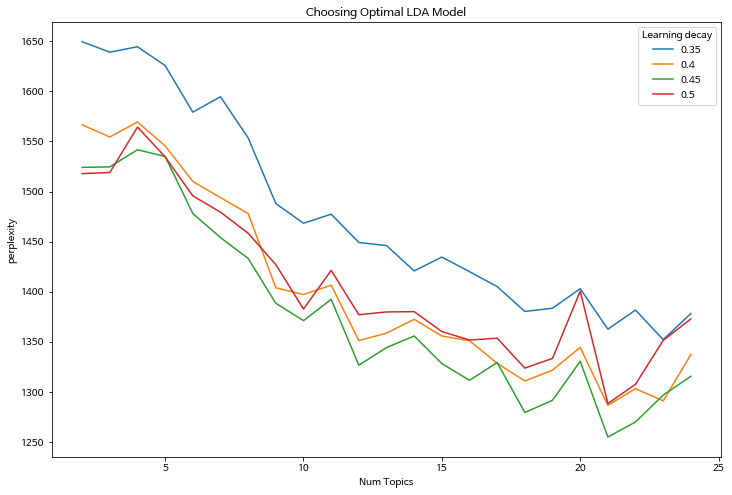

In [30]:
# reference: https://www.machinelearningplus.com/nlp/topic-modeling-python-sklearn-examples/
plt.figure(figsize=(12, 8))

for i in range(len(learning_decays)):
    plt.plot(n_topics, df_perplexity[df_perplexity.learning_decay==learning_decays[i]].perplexity, 
             label=learning_decays[i])

plt.title("Choosing Optimal LDA Model")
plt.xlabel("Num Topics")
plt.ylabel("perplexity")
plt.legend(title='Learning decay', loc='best')
plt.show()

#### cluster 숫자 결정  
decided_n_components = 21  
decided_ld = 0.45

### topic clustering

In [31]:
def get_lda_model(dict_merged_strings, decided_ld, decided_n_components, delete_words, 
                      category='benchmark'):
    """
    dict_merged_strings[category]의 lda model object와 feature 단어 list 반환.
    :param dict_merged_strings: dict. get_dict_merged_strings 함수로 처리된 결과물.
    :param decided_ld: float. learning decay.
    :param decided_n_components: int. lda topic 수
    :param delete_words: list. 삭제할 key 정보를 가진 list
    :param category: string. dict_merged_strings안의 key e.g. 'benchmark', 'personal'
    :return: dict
    """
    documents = []
    for sentence in [s for s in dict_merged_strings[category].split("\n") if s]:
        documents.append(' '.join([s for s in komoran.nouns(sentence) if s]))

    tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words=delete_words)
    tf = tf_vectorizer.fit_transform(documents)
    tf_feature_names = tf_vectorizer.get_feature_names()

    # Run LDA
    lda_model = LatentDirichletAllocation(learning_decay = decided_ld,
                                          n_components=decided_n_components, 
                                          max_iter=5, learning_method='online', 
                                          learning_offset=50.,random_state=0,
                                          doc_topic_prior=0.1, topic_word_prior=0.01,
                                         ).fit(tf)

    return lda_model, tf_feature_names

In [32]:
# reference: https://medium.com/mlreview/topic-modeling-with-scikit-learn-e80d33668730

def display_topics(model, feature_names, no_top_words):
    """
    토픽별 단어별 비중을 내림차순 정렬해서 no_top_words 만큼 보여준다.
    :param model: lda model object.
    :param feature_names: array-like.
    :param no_top_words: int.
    :return: None
    """
    for topic_idx, topic in enumerate(model.components_):
        print("Topic %d:" % (topic_idx))
        print(" ".join([feature_names[i] for i in topic.argsort()[::-1]][:no_top_words]))

In [33]:
# 클러스터 수, learning_decay 결정
decided_n_components = 21
decided_ld = 0.45

In [34]:
lda, lda_tf_feature_names = get_lda_model(dict_merged_strings, decided_ld, decided_n_components, 
                                          delete_words, category='benchmark')

In [35]:
# display
no_top_words = 10
display_topics(lda, lda_tf_feature_names, no_top_words)

Topic 0:
계획 업무 리더 계발 역할 자제력 쓰기 모습 스트레스 언어
Topic 1:
학습 습관 능력 전략 고민 장점 시대 효율 기하급수 스타트
Topic 2:
능력 포기 공감 사회 인간 시스템 스마트폰 이익 호랑이 손해
Topic 3:
방법 시도 마음 상태 이야기 사랑 개발 폭발 공짜 방식
Topic 4:
세상 고통 반응 세계 최선 공유 모형 프레임 대중 시점
Topic 5:
정보 핵심 아이디어 순간 활용 반복 최악 자유 단계 기존
Topic 6:
경험 몰입 과제 믿음 향상 극복 주변 생활 수행 불안
Topic 7:
사실 하루 독서 이용 약속 위로 상관관계 초기 거절 이후
Topic 8:
확률 성공 실패 조언 도전 군가 도움 보상 목록 경향
Topic 9:
공부 시간 노력 임계점 효과 조금 시험 승리 형성 구간
Topic 10:
행복 타인 연습 비교 대화 긍정 성취 영향 기쁨 착각
Topic 11:
회사 운동 친구 피드백 발생 적극 태도 퇴사 용기 부정
Topic 12:
분야 실력 지속 영역 전문가 전문 발휘 특정 경쟁 강연
Topic 13:
기억 직원 과거 장기 후회 건강 그룹 모두 특징 학생
Topic 14:
목표 성장 지식 인생 동기 환경 시작 부여 혁신 수준
Topic 15:
결과 감정 미래 연구 집중 재능 욕구 논문 요구 활동
Topic 16:
완벽 이상 아이디어 창의 연결 실행 자율 진행 비즈니스 관리
Topic 17:
행동 상황 평가 결정 이유 확인 설정 변화 의식 사고
Topic 18:
질문 부모 인정 호기심 고객 통제 대로 아이 문해 이메일
Topic 19:
의미 조직 관계 읽기 기회 정보 기술 판단 기준 설명
Topic 20:
인지 이해 문제 예측 해결 선택 실수 메타 상대방 과정


In [36]:
def get_lda_topic_clustering(lda_model, tf_feature_names):
    """
    topic clustering 결과를 반환한다.
    :param lda_model: lda model object.
    :param tf_feature_names: array-like.
    :return: DataFrame
    """
    df_topic_clustering = pd.DataFrame()

    for topic_idx, topic in enumerate(lda_model.components_):
        cut_off_len = len([i for i in topic if i >= 1])
        df_topic_clustering = \
            df_topic_clustering.append([[topic_idx, 
                                         [tf_feature_names[i] for i in topic.argsort()[::-1]][:cut_off_len]]]
                                       , ignore_index=True)
    df_topic_clustering.columns = ['topic_index', 'topic_words']
    df_topic_clustering.set_index('topic_index', inplace=True)

    return df_topic_clustering

In [37]:
df_topic_clustering = get_lda_topic_clustering(lda, lda_tf_feature_names)
df_topic_clustering

,topic_words
topic_index,
0,"[계획, 업무, 리더, 계발, 역할, 자제력, 쓰기, 모습, 스트레스, 언어, 사용..."
1,"[학습, 습관, 능력, 전략, 고민, 장점, 시대, 효율, 기하급수, 스타트, 준비..."
2,"[능력, 포기, 공감, 사회, 인간, 시스템, 스마트폰, 이익, 호랑이, 손해, 소..."
3,"[방법, 시도, 마음, 상태, 이야기, 사랑, 개발, 폭발, 공짜, 방식, 자기, ..."
4,"[세상, 고통, 반응, 세계, 최선, 공유, 모형, 프레임, 대중, 시점, 겸손, ..."
5,"[정보, 핵심, 아이디어, 순간, 활용, 반복, 최악, 자유, 단계, 기존, 경청,..."
6,"[경험, 몰입, 과제, 믿음, 향상, 극복, 주변, 생활, 수행, 불안, 투자, 창..."
7,"[사실, 하루, 독서, 이용, 약속, 위로, 상관관계, 초기, 거절, 이후, 도착,..."
8,"[확률, 성공, 실패, 조언, 도전, 군가, 도움, 보상, 목록, 경향, 파악, 프..."


In [38]:
# 토픽별 단어 숫자
df_topic_clustering.topic_words.apply(lambda x: len(x))

topic_index
0      41
1      53
2      44
3      47
4      43
5      81
6      48
7      35
8      61
9      62
10     56
11     55
12     38
13     61
14    104
15     50
16     81
17     70
18     39
19     79
20     81
Name: topic_words, dtype: int64

In [39]:
# label 붙이기.
df_topic_clustering_label = df_topic_clustering.copy()
df_topic_clustering_label['topic_label'] = [
    '계획', 
    '학습', 
    '능력', 
    '마음',
    '세상',
    '정보와 아이디어',
    '믿음',
    '습관',
    '성공과 도전',
    '공부',
    '행복',
    '회사내 태도',
    '실력',
    '기억',
    '목표',
    '결과',
    '창의',
    '행동',
    '호기심',
    '조직',
    '메타인지',]

In [40]:
df_topic_clustering_label[['topic_label', 'topic_words']]

,topic_label,topic_words
topic_index,,
0,계획,"[계획, 업무, 리더, 계발, 역할, 자제력, 쓰기, 모습, 스트레스, 언어, 사용..."
1,학습,"[학습, 습관, 능력, 전략, 고민, 장점, 시대, 효율, 기하급수, 스타트, 준비..."
2,능력,"[능력, 포기, 공감, 사회, 인간, 시스템, 스마트폰, 이익, 호랑이, 손해, 소..."
3,마음,"[방법, 시도, 마음, 상태, 이야기, 사랑, 개발, 폭발, 공짜, 방식, 자기, ..."
4,세상,"[세상, 고통, 반응, 세계, 최선, 공유, 모형, 프레임, 대중, 시점, 겸손, ..."
5,정보와 아이디어,"[정보, 핵심, 아이디어, 순간, 활용, 반복, 최악, 자유, 단계, 기존, 경청,..."
6,믿음,"[경험, 몰입, 과제, 믿음, 향상, 극복, 주변, 생활, 수행, 불안, 투자, 창..."
7,습관,"[사실, 하루, 독서, 이용, 약속, 위로, 상관관계, 초기, 거절, 이후, 도착,..."
8,성공과 도전,"[확률, 성공, 실패, 조언, 도전, 군가, 도움, 보상, 목록, 경향, 파악, 프..."


## topic sse score

In [41]:
def get_topic_score(dict_frequency_benchmark, dict_frequency_test, df_topic_clustering, 
                    topic_index, score_type='sse'):
    """
    get_nouns_frequency 함수로 처리된 결과 dict내의 두 value 선택하면 
    df_topic_clustering의 topic index와 연관된 주제의 단어만을 남긴다.
    단어별 빈도 비율의 차이를 0~1점 사이의 score로 반환한다.
    1점에 가까울수록 유사하다.
    :param dict_frequency_benchmark: dict. get_nouns_frequency 함수로 처리된 결과물.
    :param dict_frequency_test: dict. get_nouns_frequency 함수로 처리된 결과물.
    :param df_topic_clustering: DataFrame. get_lda_topic_clustering 함수의 결과물.
    :param topic_index: int
    :param score_type: string. choose 'sse' or 'log_sse'.
    :return: float
    """
    dict_frequency_benchmark_topic = {topic_key: dict_frequency_benchmark[topic_key] 
                                      for topic_key in df_topic_clustering.loc[topic_index, 'topic_words']
                                      if topic_key in dict_frequency_benchmark.keys()}
    dict_frequency_test_topic = {topic_key: dict_frequency_test[topic_key] 
                                 for topic_key in df_topic_clustering.loc[topic_index, 'topic_words']
                                 if topic_key in dict_frequency_test.keys()}
    
    df_benchmark = pd.DataFrame.from_dict(dict_frequency_benchmark_topic, 
                                          orient='index', columns=['word_count'])
    df_test = pd.DataFrame.from_dict(dict_frequency_test_topic, 
                                     orient='index', columns=['word_count'])

    # 1회 나온 단어 log 씌우면 0되는 것 방지
    df_benchmark['log_word_count'] = np.log(df_benchmark.word_count + 1)
    df_test['log_word_count'] = np.log(df_test.word_count + 1)
    
    df_benchmark['word_portion'] = df_benchmark.word_count.apply(
        lambda x: x / df_benchmark.word_count.sum())
    df_test['word_portion'] = df_test.word_count.apply(
        lambda x: x / df_test.word_count.sum())
    
    df_benchmark['log_word_portion'] = df_benchmark.log_word_count.apply(
        lambda x: x / df_benchmark.log_word_count.sum())
    df_test['log_word_portion'] = df_test.log_word_count.apply(
        lambda x: x / df_test.log_word_count.sum())
    
    
    df_merge = pd.merge(df_benchmark, df_test, left_index=True, right_index=True, how='outer',
                    suffixes=('_benchmark', '_test'))
    df_merge.fillna(0.0, inplace=True)
    df_merge['sse'] = (df_merge.word_portion_benchmark - df_merge.word_portion_test) ** 2
    df_merge['log_sse'] = (df_merge.log_word_portion_benchmark - df_merge.log_word_portion_test) ** 2
    
    if score_type == 'sse':
        return 1 - math.sqrt(df_merge.sse.sum())
    elif score_type == 'log_sse':
        return 1 - math.sqrt(df_merge.log_sse.sum())

In [42]:
def get_topic_scores(dict_frequency_benchmark, dict_frequency_test, df_topic_clustering, score_type='sse'):
    """
    get_nouns_frequency 함수로 처리된 결과 dict내의 두 value 선택하면 
    df_topic_clustering의 topic_index 별로 0~1점 사이의 score로 반환한다.
    1점에 가까울수록 유사하다.
    :param dict_frequency_benchmark: dict. get_nouns_frequency 함수로 처리된 결과물.
    :param dict_frequency_test: dict. get_nouns_frequency 함수로 처리된 결과물.
    :param df_topic_clustering: DataFrame. get_lda_topic_clustering 함수의 결과물.
    :param score_type: string. choose 'sse' or 'log_sse'.
    :return: float
    """
    list_result = []
    for topic_index in df_topic_clustering.index:
        list_result.append(
            [topic_index,
             get_topic_score(
                 dict_frequency_benchmark, dict_frequency_test, df_topic_clustering, topic_index)])
    df_result = pd.DataFrame(list_result, columns=['topic_index', 'topic_similarity_score'])
    df_result.set_index('topic_index', inplace=True)
    
    return df_result

In [43]:
df_topic_scores = pd.DataFrame()
for category in ['personal', '뼈아대', '일취월장', '완공', '신박사_브런치', '신영준_페이스북', '멘토_브런치', '연예_기사']:
    df_topic_score = get_topic_scores(
        dict_frequency_ppd['benchmark'], dict_frequency_ppd[category], df_topic_clustering)
    df_topic_score.columns = ['{}_score'.format(category)]
    
    df_topic_scores = pd.concat([df_topic_scores, df_topic_score], axis=1)

In [44]:
df_topic_label_score = pd.merge(df_topic_clustering_label[['topic_label']], df_topic_scores,
                                left_index=True, right_index=True)
df_topic_label_score.reset_index(inplace=True)
df_topic_label_score.set_index(['topic_index', 'topic_label'], inplace=True)

df_topic_label_score

,,personal_score,뼈아대_score,일취월장_score,완공_score,신박사_브런치_score,신영준_페이스북_score,멘토_브런치_score,연예_기사_score
topic_index,topic_label,,,,,,,,
0,계획,0.866495,0.886810,0.855691,0.859892,0.750386,0.774725,0.629981,0.352739
1,학습,0.776805,0.877298,0.903546,0.906886,0.826702,0.770661,0.594229,0.408447
2,능력,0.826980,0.846787,0.885791,0.905869,0.806652,0.778282,0.585489,0.662400
3,마음,0.848822,0.859444,0.928098,0.890548,0.706670,0.718152,0.745874,0.620542
4,세상,0.687468,0.829687,0.861431,0.780458,0.780974,0.621461,0.696077,0.413725
5,정보와 아이디어,0.842659,0.832602,0.929167,0.884855,0.784279,0.730734,0.720483,0.439273
6,믿음,0.848073,0.889248,0.888661,0.884760,0.827165,0.689067,0.719094,0.454466
7,습관,0.680236,0.817412,0.860560,0.877820,0.825860,0.532437,0.589571,0.542762
8,성공과 도전,0.862187,0.892515,0.931318,0.880492,0.834278,0.674012,0.721899,0.623747


In [45]:
n_top_bottom_topic = 3

In [46]:
df_top_n_topics = pd.DataFrame()
for column in df_topic_label_score.columns:
    df_top_n_topics = df_top_n_topics.append(
        [['_'.join(column.split('_')[:-1]),
         df_topic_label_score.reset_index().nlargest(
             n_top_bottom_topic, column).topic_label.to_list(),
         df_topic_label_score.reset_index().nlargest(
             n_top_bottom_topic, column)[column].mean()]], ignore_index=True)
df_top_n_topics.columns = ['category', 'strong_topics', 'strong_topics_mean_scores']
df_top_n_topics.set_index('category', inplace=True)

In [47]:
df_bottom_n_topics = pd.DataFrame()
for column in df_topic_label_score.columns:
    df_bottom_n_topics = df_bottom_n_topics.append(
        [['_'.join(column.split('_')[:-1]),
         df_topic_label_score.reset_index().nsmallest(
             n_top_bottom_topic, column).topic_label.to_list(),
         df_topic_label_score.reset_index().nsmallest(
             n_top_bottom_topic, column)[column].mean()]], ignore_index=True)
df_bottom_n_topics.columns = ['category', 'weak_topics', 'weak_topics_mean_scores']
df_bottom_n_topics.set_index('category', inplace=True)

In [48]:
df_strong_weak_topics = pd.merge(df_top_n_topics, df_bottom_n_topics, 
                                 left_index=True, right_index=True)
df_strong_weak_topics

,strong_topics,strong_topics_mean_scores,weak_topics,weak_topics_mean_scores
category,,,,
personal,"[행동, 계획, 목표]",0.868590,"[습관, 세상, 학습]",0.714837
뼈아대,"[메타인지, 공부, 성공과 도전]",0.901321,"[호기심, 습관, 기억]",0.817605
일취월장,"[조직, 창의, 실력]",0.942421,"[호기심, 계획, 습관]",0.853126
완공,"[행동, 학습, 능력]",0.906766,"[세상, 호기심, 기억]",0.785826
신박사_브런치,"[목표, 행동, 공부]",0.859713,"[마음, 결과, 기억]",0.727644
신영준_페이스북,"[행동, 공부, 목표]",0.812307,"[호기심, 습관, 세상]",0.546954
멘토_브런치,"[결과, 목표, 조직]",0.796131,"[능력, 습관, 학습]",0.589763
연예_기사,"[기억, 조직, 능력]",0.674441,"[계획, 학습, 세상]",0.391637
